Instantiating visualizer


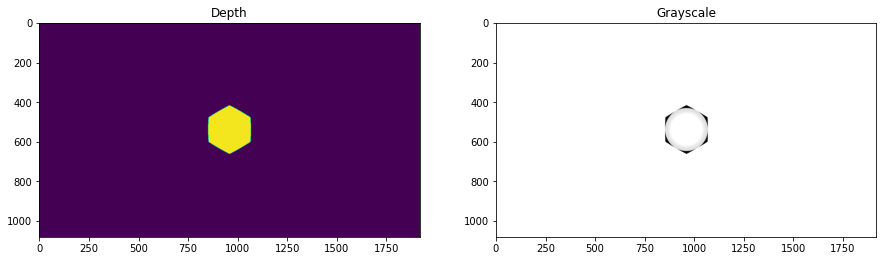

In [1]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_depthimage, show_depthimage, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis

depthimage = get_bolt_depthimage()
show_depthimage(depthimage)

x=0.0, y=0.0, z=0.0
x_rotate=0.0°, y_rotate=0.0°, z_rotate=90.0°


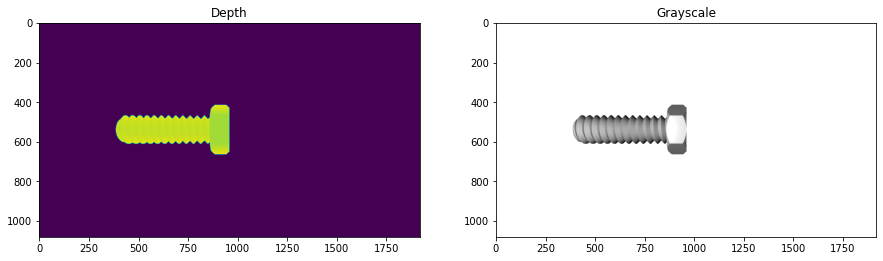

In [2]:
transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)

x=2.33, y=8.07, z=8.33
x_rotate=0.0°, y_rotate=-18.15°, z_rotate=4.94°


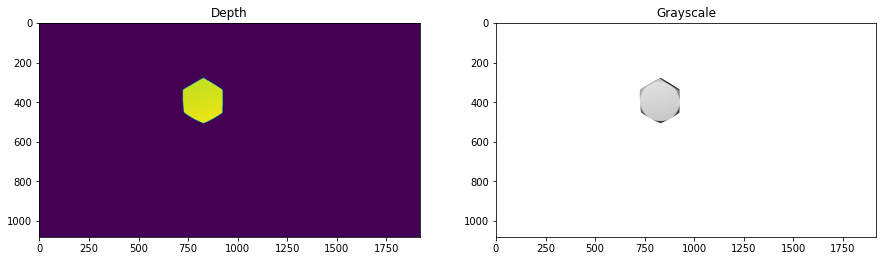

AttributeError: 'numpy.ndarray' object has no attribute 'gray'

In [3]:
transform = get_random_transform()
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)
pcd = make_pointcloud(depthimage.depth)
print('Now I\'m a point cloud. Try moving me around!')
vis.draw_geometries([pcd], moveable=False)

Truth
x=0.0, y=0.0, z=10.0
x_rotate=0.0°, y_rotate=20.0°, z_rotate=0.0°


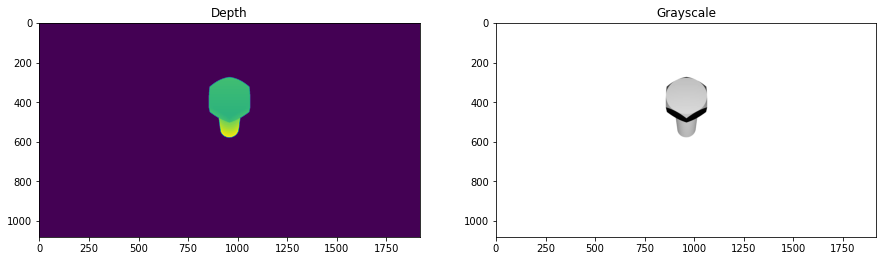

Estimate
x=4.03, y=-0.0, z=7.48
x_rotate=0.0°, y_rotate=0.0°, z_rotate=0.0°

Error: 8.392


In [4]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def rotation_between_vectors(u, v):
    # u and v are both 3D unit vectors
    axis = np.cross(u, v)
    unit = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(u, v))
    rotvec = unit * angle
    return R.from_rotvec(rotvec)


def estimator(transformed_depthimage, debug=False):
    orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
    orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

    trns_pcd = make_pointcloud(transformed_depthimage)
    trns_center = trns_pcd.get_center()
    translation = (trns_center - orig_center)
    rot = np.zeros(3) # dummy values
    rot[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
    rot = R.from_euler('xyz', rot).as_matrix()
    return TransformationMatrix.compose(rot, translation)

transform = TransformationMatrix.from_xyzwpr([0,0,10,0,20,0])
print('Truth')
print(transform)
transformed = get_bolt_depthimage(transform)
transformed_pcd = make_pointcloud(transformed)

show_depthimage(transformed)
vis.draw_geometries([transformed_pcd], moveable=False)
estimate = estimator(transformed, debug=False)
print('Estimate')
print(estimate)
from utility.pose_estimation import transform_error, evaluate_random

print('\nError:', transform_error(estimate, transform).round(3))

In [5]:
# you can use this convience function to get the loss on a random transformation
evaluate_random(estimator) 

9.60313102482848

In [6]:
import os
os.environ["DISCORD_USERNAME"] = "josiah"

In [7]:
from utility.pose_estimation import make_submission, test_images
from tqdm import tqdm

print('Estimating transformations')
estimates = np.array([estimator(img) for img in tqdm(test_images)])
make_submission(estimates)

Estimating transformations


100%|██████████| 200/200 [00:05<00:00, 33.71it/s]


Mean rmse=6.6790
Your ranking: #1

In [8]:
from utility.scoring_client import get_highscores, get_myscores, Challenge
get_highscores(Challenge.POSE)

Your Ranking: #1
            score
name             
josiah  14.555914

In [9]:
get_myscores(Challenge.POSE)

[14.555913725224011,
 14.555913725224011,
 14.555913725224011,
 14.555913725224011,
 14.555913725224011,
 14.555913725224011,
 6.679010431471446]

# Robot Control Challenge

In [10]:
from utility.remote_env import RobotorqueEnvironment

env = RobotorqueEnvironment(Challenge.ROBOT)
state = env.reset()
history = []
for _ in tqdm(list(range(10))):
    robot_positions = [state['bolt_pose'].translation[1]] * env.CONTROLS_PER_CAPTURE
    state, reward, done, info = env.step(robot_positions)
    info['rewards'] = reward
    history.append(info)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
if done:
  print('Ranking', info['ranking'])


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

   bolt position         robot visited positions  time  rewards
0          9.408  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.02    0.000
1         -7.270  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.04    0.000
2         -2.996  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.06    2.004
3         11.403  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.08    0.000
4         -3.352  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.10    1.648
5         -4.716  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.12    0.284
6         13.241  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.14    0.000
7          2.381  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.16    2.619
8         -4.740  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.18    0.260
9         14.857  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.20    0.000
Total Reward: 6.8
